# 🧪 Decoherence Decay Effect

In this visual effect we apply a delay to each qbit to observe the coherence decay of the image controling an arbitrary factor to multiple a diven delay going from 0 (no decoherence pure image) to 20 (max arbitrary decoherence). Obviously, in a ideal simulation, the image will not decay, but with a noisy simulator or real device, the image will decay. That why we have to initialize another backend with this noise model for this to work. Mind that in order to obtain a noise_model, you either have to provide ibmquantum credentials or load the included ibm_brisbane.pkl into memory for sake of brevity.

This visualization could help to understand if a circuit is long enough to start decaying as test images with simulated decoherence become familiar or the features of the decay in real backend noise models.

## Prepare Noisy Backend and Sims

You can either use backend data directly from IBMQiskit service or use the noise model we included here if you do not have an account and token

In [ ]:
import QPIXL.helper as hlp
from QPIXL.qiskit.qpixl import cFRQI
from QPIXL.qiskit.qpixl_angs import cFRQIangs, decodeAngQPIXL
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact
import os
import warnings

warnings.filterwarnings("ignore")

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel

use_remote = False
noisy_backend = None

if use_remote:
    service = QiskitRuntimeService(
        channel="ibm_quantum",
        token="...", # add your IBMQuantum token here
    )
    backend = service.backend("ibm_brisbane")
    noise_model = NoiseModel.from_backend(backend)
    noisy_simulator = AerSimulator(method='density_matrix', noise_model=noise_model)
else:
    # If you are unwillig to provide credentials or don't have an account
    # a object snapshot is included.
    # You may need to change the path to point to local absolute path
    # as path resolution of curren notebook is unpredictable in Jupyter
    T1s = [
        0.00025172438284199106, 
        0.0003629012969698477, 
        0.0003598508401631463, 
        0.00039118816145153253, 
        0.00023875650712608485, 
        0.0002704203434010988, 
        0.00035383501950940493, 
        0.000300554264232933, 
        0.0002797320000067376, 
        0.00010722972896239507, 
        0.0003607083147081156, 
        0.00016270939235588344
    ]
    from pathlib import Path
    current_dir = Path().resolve()
    file_path = os.path.join(current_dir, 'QuantumArtHack/noise_models/ibm_brisbane.pkl')
    print(file_path)
    with open(file_path, 'rb') as f:
        import pickle
        loaded_noise_model = pickle.load(f)
    noisy_simulator = AerSimulator(method='density_matrix', noise_model=loaded_noise_model)
    

Now, after defining the backend and simulator with realistic noise model, let's apply the decoherence effect to the image

In [ ]:
DIVIDEND = 5
STEPS = 20

def plot_interactive_simulated_decoherence(decoherence):
    example = hlp.examples().space
    shape = example.shape
    qc = cFRQI(example, 0)
    for _ in range (0, decoherence):
        for q in range(qc.num_qubits):
            t1 = backend.properties().t1(q) if use_remote else T1s[q]
            delay_ns = int(t1 * 1e9 / DIVIDEND) / STEPS
            qc.delay(delay_ns, q, 'ns')
        qc.barrier()
    qc.save_density_matrix()
    job = noisy_simulator.run(qc)
    result = job.result()
    rho = result.data(0)['density_matrix']  # Extract saved density matrix
    probs = np.real(np.diag(rho))
    example = hlp.decodeQPIXL(probs)
    example = hlp.reconstruct_img(example, shape).T
    plt.imshow(example)

interact(
    plot_interactive_simulated_decoherence,
    decoherence=(0, STEPS, 1),
)

Now let's visualize the grid with all the sequence of increasing decoherence from 1 to 10. Mind that this make take a few minutes!

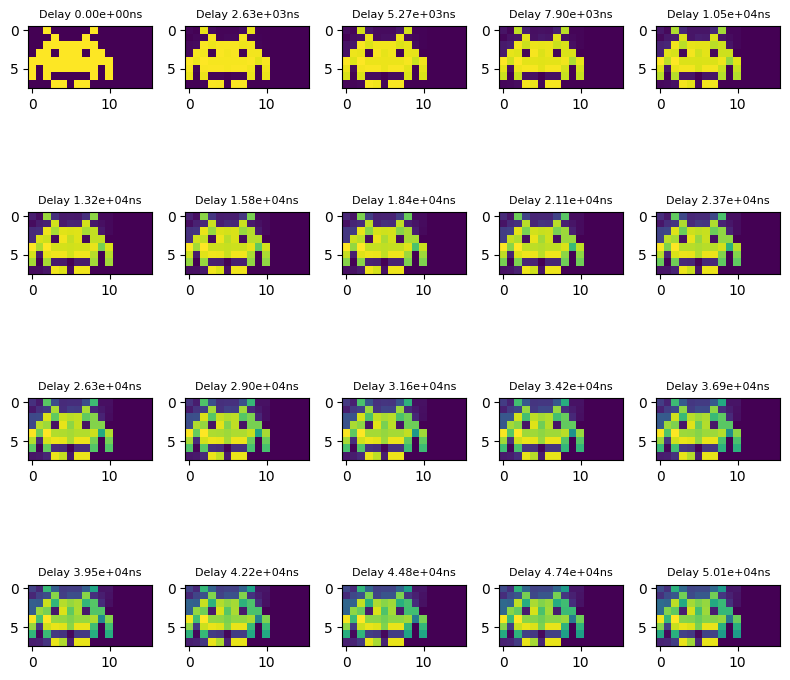

In [ ]:
DIVIDEND = 5
STEPS = 20

labels = []
gen_mats = []

for i in range(0, STEPS):
    example = hlp.examples().space
    shape = example.shape
    qc = cFRQI(example, 0)
    delay_sum = 0
    for j in range (0, i):
        for q in range(qc.num_qubits):
            t1 = backend.properties().t1(q) if use_remote else T1s[q]
            delay_ns = int(t1 * 1e9 / DIVIDEND) / STEPS
            delay_sum += delay_ns
            qc.delay(delay_ns, q, 'ns')
        qc.barrier()
    qc.save_density_matrix()
    job = noisy_simulator.run(qc)
    result = job.result()
    rho = result.data(0)['density_matrix']
    probs = np.real(np.diag(rho))
    example = hlp.decodeQPIXL(probs)
    example = hlp.reconstruct_img(example, shape).T
    delay_average = delay_sum / qc.num_qubits
    labels.append(f"Delay {delay_average:.2e}ns")
    plt.rcParams.update({'axes.titlesize': 8})  # Set smaller title font size
    gen_mats.append(example)

fig = plt.figure(figsize=(8, 8))
columns = 5
rows = 4
for i in range(0, columns * rows):
    img = gen_mats[i]
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(img)
    plt.title(labels[i])
plt.tight_layout()
plt.show()